# Image Classification with Convolutional Neural Networks in Keras

### Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

A **Convolutional Neural Network** (CNN) is a type of network architecture for deep learning algorithms, widely employed in tasks that involve the processing of pixel data.

<p align="center">
  <img src="LabSession6Images/cnn.png" width="768" style="display:block; margin-left:auto; margin-right:auto;">
</p>

A CNN for image classification usually consists in three main layers: 
* **convolutional layers** - for feature extraxtion;
* **pooling layers** - for dimensionality reduction;
* **fully connected layers** - for classification. 

## The image classification task
Image classification is the task of *assigning a class label to an entire image*.
In its simplest form, images are expected to include no more than one class (mutual exclusivity).

<p align="center">
  <img src="LabSession6Images/image_classification.png" width="768" style="display:block; margin-left:auto; margin-right:auto;">
</p>

## Framework for Neural Networks
There are several frameworks for designing neural networks based in Python, among them:
* [Caffe](https://caffe.berkeleyvision.org/);
* [Lasagne](https://github.com/Lasagne/Lasagne);
* [Jax](https://jax.readthedocs.io/en/latest/index.html)
* [TensorFlow](https://www.tensorflow.org/);
* [MXNet](https://github.com/apache/mxnet);
* [PyTorch](https://pytorch.org/).

Each framework has its own pros and cons.

### Keras
[Keras](https://keras.io/) is a deep learning API written in Python and capable of running on top of either JAX, TensorFlow, or PyTorch.

It provides to the user intuitive interfaces for:
* **Layers** (i.e. linear layer, convolutional layer);
* **Activation functions** (i.e. sigmoid, ReLU, softmax);
* **Loss functions** (i.e. cross-entropy, KL divergence);
* **Regularizers**;
* **Metrics** (i.e. accuracy, recall);
* **Optimizers** (i.e. SGD, RMSprop);
* **Models**;
* **Datasets**;

... and much more.

For further details refer to the [official documentation](https://keras.io/api/).

**Pros**
* User-Friendly and Easy to Learn;
* Modularity and Flexibility;
* Wide Adoption and Strong Community Support;
* Supports Various Backends;
* Good for Rapid Prototyping.

**Cons**
*  Limited Low-Level Customisation;
* Less Flexible for Research;
* Performance Overhead;
* Limited Debugging Tools.

## Implementing an Image Classifier with Keras

A very *high-level pipeline* for experimenting with machine learning models is devised as follows:
1. **Setup**;
2. **Data preparation**;
3. **Model building**;
4. **Model training**;
5. **Model evaluation**.

### 1. Setup

We import the usual libraries along with Keras and fix the random seeds to a known value in order to make the experiments repeatable and check if everything it is correct.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Select the CPU and TensorFlow's backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)
# Fixed random seed for repeatability.

seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

3.12.0


#### Modules and submodules
Keras is *higly modularized*. Each model component has its own module and has to be accessed or imported following the path to the module.

For instance, layers such as the 2D convolution, `Conv2D`, is implemented under the `layers` module of Keras. 

So, to correctly call `Conv2D` we can either:

1. Import it from the submodule and assign it:
```
        from keras.layers import Conv2D
        x = Conv2D(*args)
```

2. Directly assign it:
```
        x = keras.layers.Conv2D(*args)
```

### 2. Dataset preparation

The `keras.datasets` module provides some **ready-to-use toy datasets** for several different machine learning task. 
Such datasets are already-vectorized in Numpy format and they are usually employed for debugging or creating simple models. We will use these datasets as starting example.

However, Keras is also endowed with data loading utilities, located in `keras.utils`, which help you go from raw data on disk to a dataset object, which can be used to efficiently train a model.
These loading utilites can be combined with preprocessing layers to futher transform your input dataset before training (i.e. data augmentation, normalization).


*Example*

Let us say you have 10 folders, each containing 1000 images from a different category, and you want to train a classifier that maps an image to its category. Then, your training data folder would look like this:
```
training_data/
....dog/
.......dog_0001.jpg
.......dog_0002.jpg
.
.
.
....cat/
.......cat_0001.jpg
.......cat_0002.jpg
.
.
.
```
You could simply do:

```
from keras.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(directory = 'path/to/your/data',
                                        labels = 'inferred',
                                        label_mode = 'categorical',
                                        batch_size = 32,
                                        image_size = (256, 256))
```

However, for this session we will use some Keras dataset.

##### Fashion-MNIST
It is a dataset of Zalando's article images, consisting of a training set of 60k samples and a test set of 10k samples. Each sample is a 28x28 grayscale image, associated with a label from 10 different mutually exclusive classes.

<p align="center">
  <img src="LabSession6Images/fashion-mnist.png" width="512" style="display:block; margin-left:auto; margin-right:auto;">
</p>

#### Data loading [*requires internet connection*]
To retrieve the dataset it suffices to import the dataset and call the `load_data()` method on it.
The method will download, unzip and process the dataset in order to obtain a tuple for the training data and a tuple for the test data:

In [4]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Data loading [*without internet connection*]
If you are not able to download the dataset you can load it directly from the binaries:

In [60]:
def load_mnist(path, kind = 'train'):
    import gzip
    
    labels_path = os.path.join(path,f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path,f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype = np.uint8, offset = 8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype = np.uint8, offset = 16).reshape(len(labels), 28, 28)

    return images, labels

(x_train, y_train), (x_test, y_test) = load_mnist(r'datasets/fashion_mnist', 'train'), load_mnist(r'datasets/fashion_mnist', 't10k')

For convenience we will also map the labels to the names of the clothes:

In [5]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

#### Data inspection
There are several things that we can inspect in order to ensure that everything it is fine.
For instance we can start by checking whether the expected number of samples and size of the images are correct:

In [6]:
n_train, w_train, h_train = x_train.shape
n_test, w_test, h_test = x_test.shape
unique_labels = np.unique(y_train)
n_classes = len(unique_labels) # N.B. np.unique(x) returns the list of unique values inside the array x.

print(f"There are {n_train} samples in the training set, with size ({w_train},{h_train}).")
print(f"There are {n_test} samples in the test set with, size ({w_test},{h_test}).")
print(f"There are {n_classes} different classes.")
print(f"The unique labels are {unique_labels}.")

There are 60000 samples in the training set, with size (28,28).
There are 10000 samples in the test set with, size (28,28).
There are 10 different classes.
The unique labels are [0 1 2 3 4 5 6 7 8 9].


Note that checking the number of classes by checking the number of unique values in the training set means that we are hypothesizing that the class distribution of the input data it is the same of the output data, i.e. every class in the test set is also in the training set.

Let us then extract a random index to visually inspect some images of the training set:

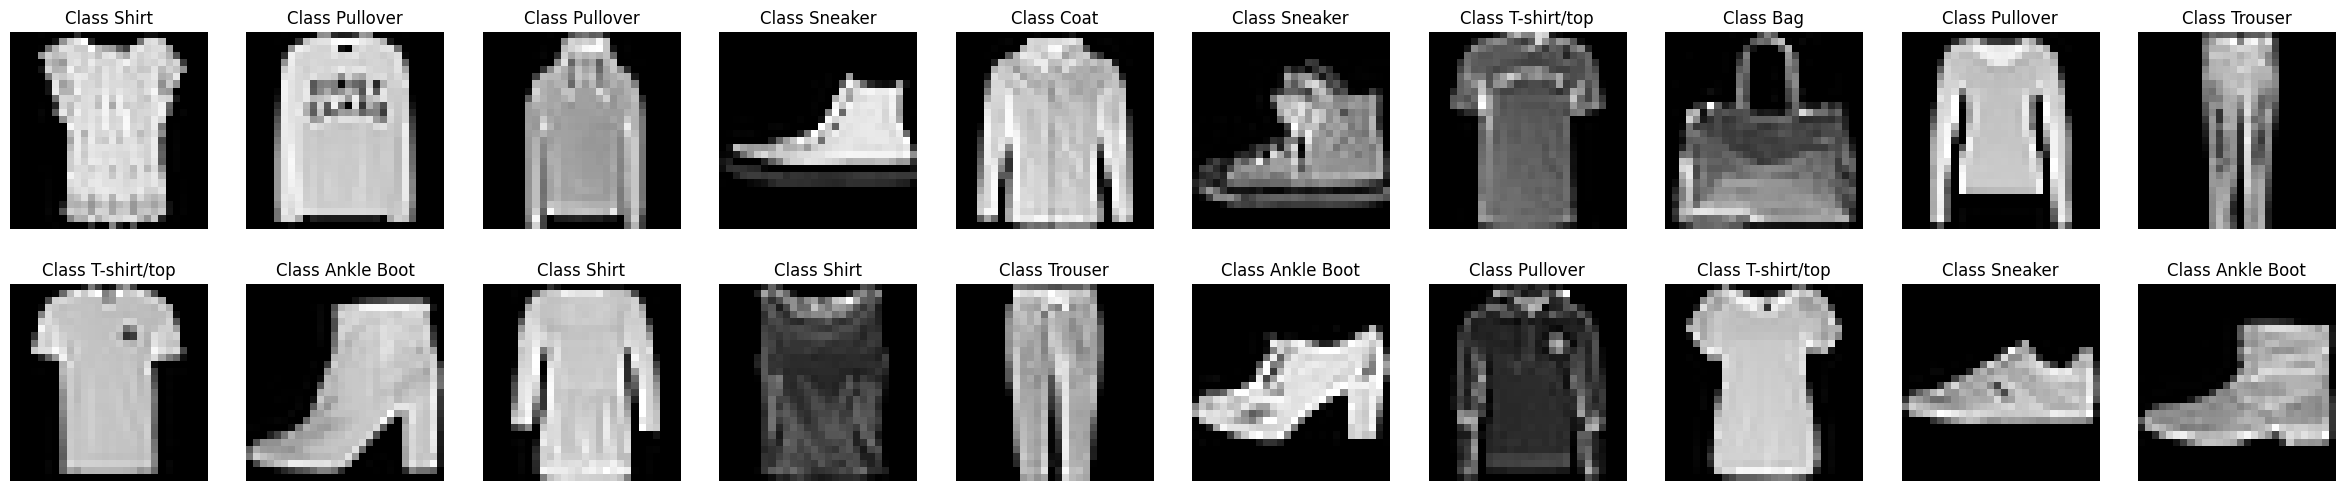

In [8]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel() # linearizziamo la matrice di axes
for i in range(20):
    rand_idx = np.random.randint(0, x_train.shape[0])
    ax[i].set_axis_off() # toglie dettagli degli assi come tick, numerazione, ecc.
    ax[i].set_title(f"Class {labels[y_train[rand_idx]]}")
    ax[i].imshow(x_train[rand_idx], vmin = x_train[rand_idx].min(), vmax = x_train[rand_idx].max(), cmap = "gray")

Then, we can check the range of these images:

In [9]:
print(f"The images are in the range [{np.min(x_train)},{np.max(x_train)}].")

The images are in the range [0,255].


These images are all in the range $[0,255]$.

#### Data normalisation
In general, it is a good practice to normalise the input data of a machine learning model (for certain kinds of models, it can also be mandatory) for two main reasons:
1. After normalisation, all data lies in the same interval, and so metrics and losses based on similarities make sense;
2. Smaller data begets smaller weights and hence a more efficient learning.

In this case we simple rescale in the $[0,1]$ range:

In [10]:
x_train = x_train.astype('float') / np.max(x_train)
x_test = x_test.astype('float') / np.max(x_test)

print(f"The new range of the images is [{x_train.min()},{x_train.max()}].")

The new range of the images is [0.0,1.0].


Then, since these images are grayscale we need to add a dimension that takes into account the dimensionality of the channel:

In [11]:
if x_train.shape[-1] != 1:
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

print(f"The new shape of the feature matrix is: {x_train.shape}.")

The new shape of the feature matrix is: (60000, 28, 28, 1).


In case of RGB images this is not necessary since they already have 3 channels.

### 3. Model building
To start we will implement a simple CNN with two convolutional layers with subsequent max pooling and a final fully connected layer:

<p align="center">
  <img src="LabSession6Images/base_model.png" width="768" class="center" style="display:block; margin-left:auto; margin-right:auto;">
</p>

As mentioned before, we need to extract from the `layers` submodule the layers of interest:

In [12]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

Here listed some simplified interfaces of layers that we will employ:
* `Input(shape, ...)` - we can specify the shape of the input, in the form (h,w,c);
* `Flatten()` - unroll the input;
* `Dense(units, activation, ...)` - we can specify the number of neurons - in the case of classification equal to the number of classes - and the type of activation function of the output;
* `MaxPooling2D(pool_size, ...)` - we can specify the size of the pooling - bidimensional since we are using a 2d pooiling;
* `Conv2D(filters, kernel_size, activation, padding, ...)` - we can specify the number of stacked filters, the size of the kernel - bidimensional since we are using a 2d convolution, the type of activation function of the output and how the padding is performed.

In [13]:
input_shape = x_train.shape[1:]
print(f"The input shape of the CNN is {input_shape}.")

The input shape of the CNN is (28, 28, 1).


We can leverage on Keras sequential model to easily build our neural network as a stack of layers:

In [16]:
model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes, activation = "softmax")
    ]
)

We can use the `summary()` method to obtain an overview of the model:

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

Alternatively, that are a lot of already implemented model (such as ResNet and VGG, more info on the [official documentation](https://keras.io/api/applications/)), directly loadable from Keras:

In [18]:
from keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(weights = None)

resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 4. Model training
As before, we need to extract from the `optimizers` and `losses` submodules the objects of interest:

In [20]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()

And we add them to the model:

In [21]:
model.compile(loss = loss_fcn,
              optimizer = opt, 
              metrics = ["accuracy"]) 

Then, we set some others hyperparameters, such as:
* `batch_size` - number of samples that will be propagated through the network at each iteration;
* `epochs` - number of complete pass on the training data;

and also:
* `val_split_percentage` - percentage of training data to reserve as validation at each iteration.

In [22]:
batch_size = 128
epochs = 8
val_split_percentage = 0.25

Then, we can start the model training:

In [23]:
model.fit(x_train, 
          y_train, 
          batch_size = batch_size, 
          epochs = epochs, 
          validation_split = val_split_percentage);

Epoch 1/8


2025-12-12 10:45:39.247489: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 141120000 exceeds 10% of free system memory.


352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7890 - loss: 0.5962 - val_accuracy: 0.8578 - val_loss: 0.4029
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.8683 - loss: 0.3737 - val_accuracy: 0.8675 - val_loss: 0.3683
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.8846 - loss: 0.3282 - val_accuracy: 0.8804 - val_loss: 0.3338
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8940 - loss: 0.3005 - val_accuracy: 0.8893 - val_loss: 0.3112
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9009 - loss: 0.2796 - val_accuracy: 0.8960 - val_loss: 0.2939
Epoch 6/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9066 - loss: 0.2628 - val_accuracy: 0.9008 - val_loss: 0.2800
Epoch 7/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9119 - loss: 0.2480 - val_accuracy: 0.9043 - val_loss: 0.2693
Epoch 8/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9167 - loss: 0.2349 - val_accuracy: 0.90

### 5. Model evaluation
We can also visualize the model accuracy and loss for the training and the validation sets. 
Since the validation set is class-balanced, accuracy provides an unbiased representation of the model's performance.

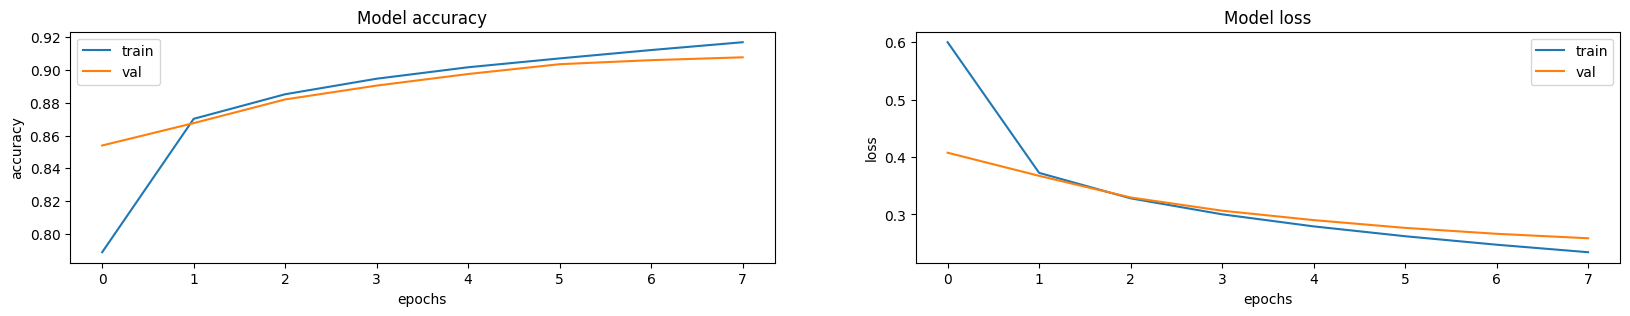

In [77]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

Then, we can perform inference on the test data and assess the metrics:

In [78]:
test_loss, test_metric = model.evaluate(x_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9008 - loss: 0.2777
The test loss is 0.2777, the test accuracy is 0.9008.


Note that the `evaluate()` method just return the metric and loss values, not the predictions.

If we want to inspect the prediction we can leverage on the `predict()` method:

In [79]:
pred = model.predict(x_test)
print("Test Input Shape: {} Test output shape: {}".format(x_test.shape, pred.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Input Shape: (10000, 28, 28, 1) Test output shape: (10000, 10)


The returned value is an array with dimension `[n_test, n_classes]`. This output represents probability distribution of the prediction. Indeed, if we sum over the classes, for each sample, we will obtain (almost) 1. 

In [80]:
print(np.sum(pred, axis=-1))

[1.         1.0000001  1.         ... 1.0000001  0.9999998  0.99999994]


To find the corresponding classes it suffices to find in which classes we have the maximum probability:

In [81]:
pred = np.argmax(pred, axis = -1)
print(pred)

[9 2 1 ... 8 1 5]


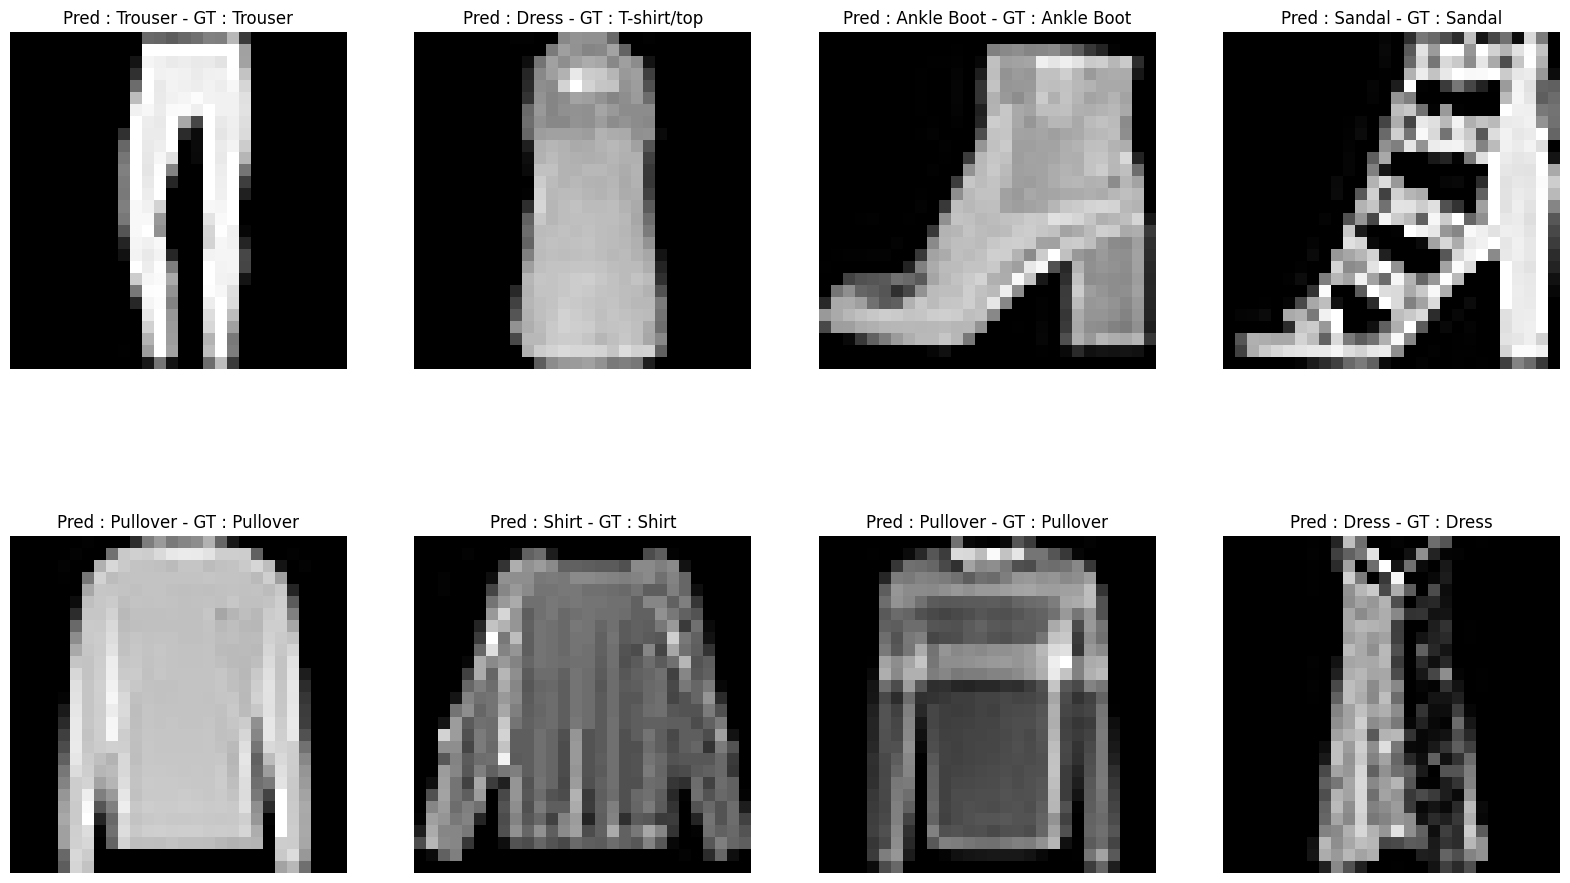

In [82]:
plt.figure(figsize=(20,12))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    rand_idx = np.random.randint(0, x_test.shape[0])
    plt.axis('off')
    plt.title(f"Pred : {labels[pred[rand_idx]]} - GT : {labels[y_test[rand_idx]]}")
    plt.imshow(x_test[rand_idx], cmap = "gray")
plt.show()

### Saving and loading a model
With the method `save()`, embedded in your model, it is possible to save a model's architecture, weights, and training configuration in a single folder. Since the optimizer state is also recovered, you can resume training from exactly where you left off.

The model can be saved in two different file formats:
* **.keras** format - default file format in keras
* **HDF5** format - more general and can be seamlessly employed by other frameworks as well.

In [83]:
model.save(filepath = r'ckpts/your_model.keras')

Then, you can also reload a previously saved model:

In [84]:
reloaded_model = keras.saving.load_model('ckpts/your_model.keras')

# Check its architecture
reloaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,560 (588.13 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,374 (392.09 KB)

And eventually resume the training:

In [85]:
reloaded_model.fit(x_train, 
                   y_train, 
                   batch_size = batch_size, 
                   epochs = 2, 
                   validation_split = val_split_percentage)

Epoch 1/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9221 - loss: 0.2224 - val_accuracy: 0.9107 - val_loss: 0.2531
Epoch 2/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9258 - loss: 0.2113 - val_accuracy: 0.9107 - val_loss: 0.2483


### Pre-trained Models

Let us try to use [ResNet50](https://arxiv.org/pdf/1512.03385), a widely popular convolutional backbone. 

We use the backbone pre-trained on [ImageNet](https://www.image-net.org/) on a random image. ImageNet is a large-scale visual database designed for use in image recognition research. It contains over 14 million labeled images across thousands of categories, ranging from everyday objects to animals and scenes. To use this model we can do as follows:

In [86]:
resnet_model = keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="resnet50",
)

Or we can use the pre-downloaded weights available in the folder:

In [87]:
resnet_model = ResNet50(weights = 'weights/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

To see if it works we will load a test image and run an inference on it:

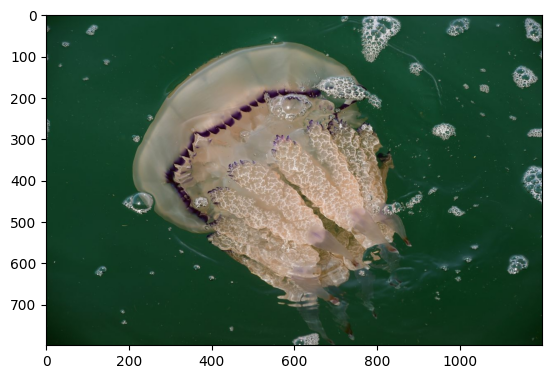

In [88]:
test_image = cv2.imread(r'test_images/jelly.jpg', cv2.IMREAD_UNCHANGED)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )

plt.imshow(test_image)
plt.show()

We also need to resize the image to make it compatible with the input of the ResNet (224x224):

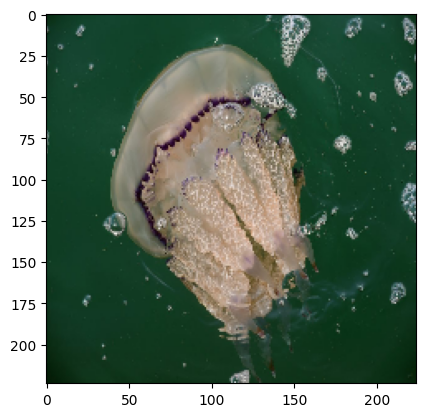

In [89]:
test_image = cv2.resize(test_image, (224, 224))

plt.imshow(test_image)
plt.show()

Then, we also need to add a dimension in order to simulate an unitary "batch" for the inference:

In [90]:
test_image = test_image.reshape((1, 224, 224, 3))
pred_image = resnet_model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


If we inspect the prediction we will see that we have a 1000-dimensional vector (as the number of classes that ResNet pre-trained on ImageNet can predict). This vector represents the probability distribution of the prediction.
Indeed, if we sum everything we will obtain (almost) 1:

In [91]:
print(f'The shape of the prediction is: {pred_image.shape}')
print(f'The sum of the prediction is: {pred_image.sum():.2f}')

The shape of the prediction is: (1, 1000)
The sum of the prediction is: 1.00


To find the corresponding class it suffices to find in which class we have the maximum probability:

In [92]:
pred_class = np.argmax(pred_image, axis = 1).item()
print(f'The predicted class is {pred_class}.')

The predicted class is 107.


And if we check the [labels](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/), it corresponds to the **jellyfish** class.

### Public datasets
If you want to play with other datasets you may find many other datasets on public repositories such as [Kaggle](https://www.kaggle.com/datasets) or [AIcrowd](https://www.aicrowd.com/).